In [1]:
"""
## Purpose of script: Segment and visualise bird specimen images using thresholding, region growing, chan-vese and graph cut. 
##
## Author: Yichen He
## Date: 2022/07
## Email: csyichenhe@gmail.com
"""

import pandas as pd
import numpy as np
import os,sys
import re
import cv2
from scipy import stats,ndimage

import matplotlib.pyplot as plt
%matplotlib inline
from skimage.segmentation import morphological_chan_vese



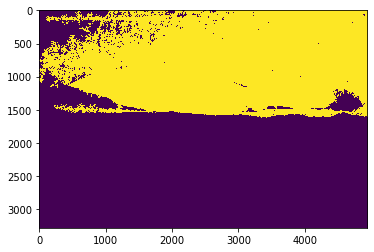

In [13]:
#### Thresholding with the modal of images ####

# read an example image
img = cv2.imread("data/img/Acanthagenys_rufogularis_1_M_Back_Vis_Y070374.jpg")
scale=1
height, width = img.shape[:2]

## preprocessing- resize, convert to gray scale, gaussian blur the images.
img = cv2.resize(img,(width//scale, height//scale))
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.GaussianBlur(img,(11,11),cv2.BORDER_REFLECT)


# modal plus 15 offset and apply thresholding
threshold = (stats.mode(img.flatten())[0][0] + 15)

ret, thresh = cv2.threshold(img, threshold,
                            255,cv2.THRESH_BINARY)

## post-processing 
# morpho close and open
kernel = np.ones((5,5),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 1)

closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel , iterations = 1)

# Get the connected componenets that have area larger than 2500 pixel^2
nb_components, output, sizes, centroids = cv2.connectedComponentsWithStats(closing, connectivity=8)
sizes = sizes[1:, -1]; nb_components = nb_components - 1
min_size = 2500

for i_seg,size in enumerate(sizes):
    if size > min_size:
        final_mask = output ==i_seg +1
        break

##plot the mask
final_mask = final_mask.astype('uint8')
final_mask = cv2.resize(final_mask, (4948 , 3280))
plt.imshow(final_mask)



In [3]:
## Read the point annotation file for region growing, chan-vese and graph cut
df_point = pd.read_csv("data/demo_point_annotations.csv",index_col='file.vis')

coords_cols = ['crown_x', 'crown_y', 'nape_x','nape_y', 'mantle_x', 'mantle_y', 'rump_x', 'rump_y', 'tail_x','tail_y', 
        'throat_x', 'throat_y', 'breast_x', 'breast_y', 
 'belly_x','belly_y', 'coverts_x', 'coverts_y', 'flight_feathers_x','flight_feathers_y']

std_cols = ['s02.standard_x', 's02.standard_y', 's20.standard_x', 's20.standard_y','s40.standard_x',
            's40.standard_y', 's80.standard_x', 's80.standard_y','s99.standard_x', 's99.standard_y']

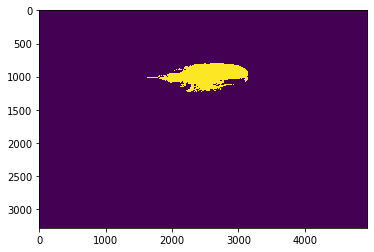

In [25]:
#### Region growing ####

img_name = "Abeillia_abeillei_1_M_Back_Vis_G199130.jpg"
img = cv2.imread("data/img/" + img_name) 
scale=1

# parameters for region growing
floodflags = 4
floodflags |= cv2.FLOODFILL_MASK_ONLY
floodflags |= cv2.FLOODFILL_FIXED_RANGE

# parameters for region growing upper and lower boundary
lower = 6
upper = 30

height, width = img.shape[:2]


## preprocessing- resize, convert to gray scale, gaussian blur the images.
img = cv2.resize(img,(width//scale, height//scale))
img = cv2.GaussianBlur(img,(5,5),cv2.BORDER_REFLECT)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
final_mask = np.zeros((img.shape[0],img.shape[1]),np.uint8)


### place the seeds using the point annotations

# find the row int the point annotation file
row = df_point.loc[img_name,]
for col_x, col_y in zip(coords_cols[::2] , coords_cols[1::2]):
    x = row[col_x]
    y = row[col_y]
    if x !=-1:

        seed_pt = (int(x//scale),int(y//scale))            
        mask = np.zeros((img.shape[0]+2,img.shape[1]+2),np.uint8)

        value = img[seed_pt[1] , seed_pt[0]]
        temp_lower = lower
        temp_upper = upper
        # if value >mode and value - lower <= mode:
        #     temp_lower = 0
        # if value< mode and value + upper >=mode:
        #     temp_upper = 0

        a = cv2.floodFill(img, mask, seed_pt, 255, loDiff = temp_lower,
                          upDiff = temp_upper, flags  = floodflags )

        mask = mask[1:-1,1:-1]

        final_mask = np.logical_or(final_mask,mask)

# post processing
final_mask = ndimage.binary_fill_holes(final_mask)

plt.imshow(final_mask)

In [33]:
    
row = df_point.loc[img_name,]
for col_x, col_y in zip(coords_cols[::2] , coords_cols[1::2]):
    x = row[col_x]
    y = row[col_y]

    if x !=-1:
       
        
        y_l = int((y-10)//scale)
        y_u = int((y+10)//scale)

        x_l = int((x-10)//scale)
        x_u = int((x+10)//scale)
        final_init[y_l:y_u , x_l:x_u]=1


[1935, 2077, 2283, 2593, 2925]

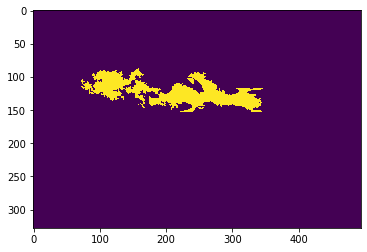

In [41]:
### Chan vese ####
img_name = "Acanthagenys_rufogularis_1_M_Back_Vis_Y070374.jpg"

img = cv2.imread("data/img/" + img_name) 

# pre-processing
scale=10
height, width = img.shape[:2]
img = cv2.resize(img,(width//scale, height//scale))
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

init = np.zeros((img.shape[0],img.shape[1]),np.uint8)


## use the point coordinates as the initial information for chan-vese    
row = df_point.loc[img_name,]
for col_x, col_y in zip(coords_cols[::2] , coords_cols[1::2]):
    x = row[col_x]
    y = row[col_y]

    if x !=-1:
       
        
        y_l = int((y-10)//scale)
        y_u = int((y+10)//scale)

        x_l = int((x-10)//scale)
        x_u = int((x+10)//scale)
        init[y_l:y_u , x_l:x_u]=1


# apply chan-vese
mask = morphological_chan_vese(img, iterations=100,init_level_set=init,smoothing=0)
# post processing
mask = ndimage.binary_fill_holes(mask)


plt.imshow(mask)


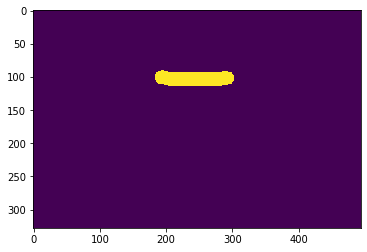

In [18]:
### Graph cut ####

img_name = 'Abeillia_abeillei_1_M_Back_Vis_G199130.jpg'
img = cv2.imread('data/img/' + img_name )
# pre-processing
scale=10
height, width = img.shape[:2]
img = cv2.resize(img,(width//scale, height//scale))


# init the background and foreground model
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

## init the mask as the input of graph cut (1: foreground. 0 background)
mask = np.zeros(img.shape[:2],np.uint8)
row = df_point.loc[img_name,]        
## draw lines between body region points for the foreground
x_list=[]
y_list=[]
for col_x, col_y in zip(coords_cols[::2] , coords_cols[1::2]):
    x = row[col_x]
    y = row[col_y]

    if x !=-1:
        x_list.append(x)
        y_list.append(y)

if len(x_list) == 1:
    y_l = int((y_list[0]-50)//scale)
    y_u = int((y_list[0]+50)//scale)

    x_l = int((x_list[0]-100)//scale)
    x_u = int((x_list[0]+100)//scale)
    final_init[y_l:y_u , x_l:x_u]=1
else:
    for i in range(len(x_list)-1):

        y_1 = int((y_list[i])//scale)
        y_2 = int((y_list[i+1])//scale)

        x_1 = int((x_list[i])//scale)
        x_2 = int((x_list[i+1])//scale)

        cv2.line(mask, (x_1,y_1), (x_2,y_2), 1, 20)
        


cv2.grabCut(img,mask,None,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_MASK)

mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask2[:,:,np.newaxis]
                
plt.imshow(mask2)